#Simulating Evolutionary Strategies with the Iterated Prisoner's Dilemma

Implementing several agent behaviours in python (3) playing the iterated version of the Prisoner's Dilemma (IPD). The main objective is to observe the emergence of altruistic strategies as winning ones. 

The simulations implemented run all possible IPD games between pairs of agents and the evolutionary development of a fixed size population on a number of generations. They reproduce the spirit of the tournaments firstly held by Axelrod and successfully by the game theory community.

----
A project for the course on Complex Systems held by Prof. H. Bersini

_av_ - an irreducible reductionist

## Requirements

In order to run this notebook or the attached code the following packages and softwares are required:
    
   * numpy
   * pandas
   * matplotlib, seaborn
   * optionally, PlantUML for showing uml diagrams (jar in the same folder)

In [50]:
# PlantUML setup
%install_ext https://gist.githubusercontent.com/sberke/7360a4b7aa79aefccbb0/raw/f19a8910c847421977daa7a8c893bb7d77aa78b5/plantuml_magics.py
%load_ext plantuml_magics

import glob
glob.glob(r'./*.jar')

Installed plantuml_magics.py. To use it, type:
  %load_ext plantuml_magics
The plantuml_magics extension is already loaded. To reload it, use:
  %reload_ext plantuml_magics


['./plantuml.jar']

In [51]:
#
# imports
import numpy
import pandas

from abc import ABCMeta
from abc import abstractmethod

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Prisoner's Dilemma

The _**Prisoner's Dilemma**_ (**PD**), is a two-player perfect information game in which each player has one decision to take: either to _cooperate_ (**C**) or to _defect_ (**D**).
The payoffs for their choices are given in this way:
 <table style="width:200px">
  <tr>
    <td></td>
    <td><strong>C</strong></td>
    <td><strong>D</strong></td>
  </tr>
  <tr>
    <td><strong>C</strong></td>
    <td><em>R,R</em></td>
    <td><em>S,T</em></td>
  </tr>
  <tr>
    <td><strong>D</strong></td>
    <td><em>T,S</em></td>
    <td><em>P,P</em></td>
  </tr>
</table> 

According to this formulation, for any $T > R > P > S$, the Nash Equilibrium of the game is for both players to defect (D, D).

Its fame comes from the fact that it was one of the first games used in game theory in which a Nash equilibrium is not the Pareto one (C, C). This is used to demonstrate the _rational_ behaviour of a single agent; this goes to show how cooperation, or altruism, may not be rationally pursued.

Cite Hofstadter's **_superrational_** behaviour as an attacking argument for the classical definition of rationality in decision making.

##Iterated Prisoner's Dilemma
The _**Iterated Prisoner's Dilemma**_ (**IPD**) is the repeated version of the previous game, in which there are always two players and a fixed payoff matrix (for which $2R > T + S$ must hold). The players play $N$ games at the end of which the winner is the one of the two who has 

The repetitivity of the game introduces some key differences:

    
   * there are more than 4 strategies
   * information about the other player behaviour is more valuable
   * cooperation at later stages is more meaningful, provided a way to create trust

Question: _is it always true that strategies that defect are the most successful?_
Again, a rational agent would always defect since it can be inductively proved that this is a dominant strategy.

###Axelrod's 1979 tournament


###Axelrod's 1982 tournament

##Modeling

Each implemented agent is an object of the class **IPDPlayer**, for which many subclasses will be provided to model different strategies. Each player has a global id, and a local one (useful to determine who is the 'first' in each game). A string is kept as a label representing the agent's type.

The implementation of a IPD game exploits the class **IPDGame** which is responsible to simulate the $N$ iterations of the game . At each iteration, both players are asked to act, i.e. to say 0 (C) or 1 (D). The actions and rewards for both players and every iterations are stored (and potentially accessible for particular kinds of agents).

A simple, exhaustive, simulation is done by the means of the class **IPDPairwiseCompetition** which is responsible for executing all the possible pairwise games among the player instances it owns.

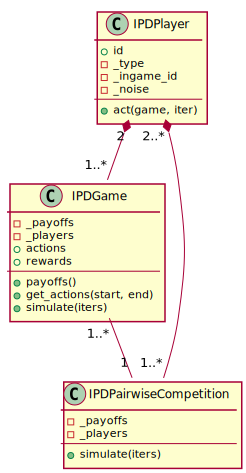

In [52]:
%%plantuml uml/class-diagram-1

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    -_noise
    --
    +act(game, iter)
}
class IPDGame{
    -_payoffs
    -_players
    +actions
    +rewards
    --
    +payoffs()
    +get_actions(start, end)
    +simulate(iters)
}
class IPDPairwiseCompetition{
    -_payoffs
    -_players
    --
    +simulate(iters)
}
IPDPlayer "2" *-- "1..*" IPDGame
IPDGame "1..*" -- "1" IPDPairwiseCompetition
IPDPairwiseCompetition "1..*" --* "2..*" IPDPlayer
@enduml 

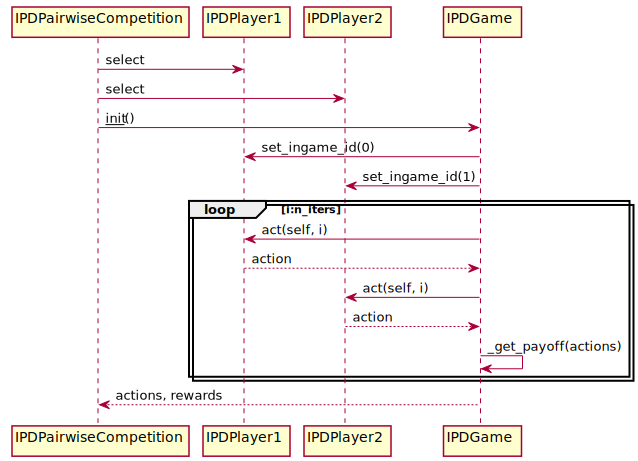

In [53]:
%%plantuml uml/sequence-competition

@startuml
IPDPairwiseCompetition -> IPDPlayer1: select
IPDPairwiseCompetition -> IPDPlayer2: select
IPDPairwiseCompetition -> IPDGame: __init__()
IPDGame -> IPDPlayer1: set_ingame_id(0)
IPDGame -> IPDPlayer2: set_ingame_id(1)    
    loop i:n_iters
        IPDGame -> IPDPlayer1: act(self, i)
        IPDPlayer1 --> IPDGame: action
        IPDGame -> IPDPlayer2: act(self, i)
        IPDPlayer2 --> IPDGame: action
        IPDGame -> IPDGame: _get_payoff(actions)
    end
    IPDGame --> IPDPairwiseCompetition: actions, rewards
@enduml 

In [54]:
# %load -s IPDGame pd.py
class IPDGame(object):

    """
    Representing a two players Iterated Prisoner's Dilemma game (IPD)
    """

    def __init__(self,
                 players,
                 payoffs,
                 obs_noise=0.0):
        """
        WRITEME
        """
        self._payoffs = payoffs
        self._players = players
        self._n_players = len(players)

        #
        # noise in payoffs as seen by players
        self._noise = obs_noise

        #
        # a game will have a history of actions and rewards when simulated
        self.actions = None
        self.rewards = None

    def _gen_noisy_channel(self):
        return numpy.random.randn(self._payoffs.shape) * self._noise

    def payoffs(self):
        """
        WRITEME
        """
        return self._payoffs  # + self._gen_noisy_channel()

    def get_actions(self, iter_start, iter_end):
        """
        Return the actions for the previous iterates
        """
        # print(iter_start, iter_end)

        #
        # adding a corrupted version

        corrupted_actions = numpy.random.binomial(1, self._noise, self.actions.shape).astype(bool)
        # print('corr', corrupted_actions)
        real_actions = self.actions.astype(bool)
        # print('real', real_actions)
        observable_actions = numpy.logical_xor(corrupted_actions, real_actions)

        # print('xor', observable_actions)
        # return self.actions[:, iter_start:iter_end]

        return observable_actions[:, iter_start:iter_end]

    def _get_payoffs(self, actions):
        """
        Accessing matrix payoffs
        """
        return self._payoffs[[[a] for a in actions]]

    @classmethod
    def build_payoff_matrix(cls, n_players, n_actions):
        """
        For a 2 players game with 2 actions the matrix
        2 x 2 x 2 (n_actions x n_actions x n_players)
        """
        geometry = [n_actions for i in range(n_players)] + [n_players]
        return numpy.zeros(geometry)

    @classmethod
    def repr_action(cls, action):
        """
        0 = 'C' = 'Cooperate'
        1 = 'D' = 'Defect'
        """
        action_str = '*'
        if action == 0:
            action_str = 'C'
        elif action == 1:
            action_str = 'D'

        return action_str

    @classmethod
    def visualize_actions_text(cls, players, actions, rewards):
        """
        WRITEME
        """
        n_iters = actions.shape[1]
        n_players = len(players)

        for p in range(n_players):
            print('\n{0}:'.format(players[p]), end=' ')
            for i in range(n_iters):
                print(IPDGame.repr_action(actions[p, i]), end='')
            print('  [{}]'.format(format(rewards[p].sum())), end='')

    def simulate(self,
                 iters=None,
                 printing=False):
        """
        WRITEME
        """
        if iters is None:
            iters = self._n_iters

        #
        # allocating players rewards and actions for the game
        self.rewards = numpy.zeros((self._n_players, iters))
        self.actions = numpy.zeros((self._n_players, iters), dtype=int)

        for i in range(iters):
            for p_id, p in enumerate(self._players):
                self.actions[p_id, i] = p.act(self, i)
                # print('\t{0}: {1}'.format(p, IPDGameSimulation.repr_action(actions[p.id, i])))
            self.rewards[:, i] = self._get_payoffs(self.actions[:, i])
            # print(self._game.actions)

        #
        # printing
        if printing:
            IPDGame.visualize_actions_text(self._players,
                                           self.actions,
                                           self.rewards)

        return self.actions, self.rewards


In [ ]:
# %load -s IPDPairwiseCompetition pd.py
class IPDPairwiseCompetition(object):

    def __init__(self,
                 players,
                 payoffs,
                 n_iters,
                 obs_noise=0.0):
        """
        WRITEME
        """
        self._n_iters = n_iters
        self._players = players
        self._payoffs = payoffs

        self._noise = obs_noise
        # self.curr_iter = 0
        self._eps = 1e-5

    def simulate(self, n_iters=None, printing=True):
        """
        WRITEME
        """

        if n_iters is None:
            n_iters = self._n_iters

        #
        # allocating stats matrix
        n_players = len(self._players)
        n_games = 0
        scores = numpy.zeros((n_players, n_players))
        #
        # an array for #victories, #draws, #losses
        victories = numpy.zeros((n_players, 3), dtype=int)
        # draws = numpy.zeros(n_players, dtype=int)

        for p_1 in range(n_players):

            player_1 = self._players[p_1]
            player_1.set_ingame_id(0)

            #
            # not playing against itself
            for p_2 in range(p_1 + 1, n_players):

                player_2 = self._players[p_2]
                player_2.set_ingame_id(1)

                n_games += 1
                if printing:
                    print('\n\ngame #{}:'.format(n_games), end='')

                #
                # create a new 2 player ipd game
                game = IPDGame([player_1, player_2],
                               self._payoffs,
                               self._noise)

                #
                # collecting stats
                actions, rewards = game.simulate(n_iters, printing)
                scores[p_1, p_2] = rewards[0, :].sum()
                scores[p_2, p_1] = rewards[1, :].sum()

                n_draws = (numpy.abs(rewards[0, :] - rewards[1, :]) < self._eps).sum()
                p_1_victories = (rewards[0, :] > rewards[1, :]).sum()
                p_2_victories = (rewards[0, :] < rewards[1, :]).sum()

                victories[p_1, 1] += n_draws
                victories[p_2, 1] += n_draws
                victories[p_1, 0] += p_1_victories
                victories[p_2, 0] += p_2_victories
                victories[p_1, 2] += p_2_victories
                victories[p_2, 2] += p_1_victories
                # else:

        # if printing:
        #    IPDPairwiseCompetition.visualize_stats_text(self._players,
        #                                                scores,
        #                                                victories,
        #                                                n_iters)

        #
        # create a pandas dataframe for later reuse
        results = IPDPairwiseCompetition.scores_to_frame(self._players, scores, victories)

        # print('results')
        # print(results)

        return results

    @classmethod
    def scores_to_frame(cls, players, scores, victories):
        """
        WRITEME
        """
        #
        # creating columns
        ids = [p.id for p in players]
        p_types = pandas.Series({p.id: p._type for p in players})
        p_scores = pandas.Series(scores.sum(axis=1), index=ids)
        p_wins = pandas.Series(victories[:, 0], index=ids)
        p_draws = pandas.Series(victories[:, 1], index=ids)
        p_losses = pandas.Series(victories[:, 2], index=ids)

        #
        # composing table
        frame = pandas.DataFrame({'types': p_types,
                                  'scores': p_scores,
                                  'wins': p_wins,
                                  'draws': p_draws,
                                  'losses': p_losses})

        #
        # imposing column order
        frame = frame[['types', 'scores', 'wins', 'draws', 'losses']]
        frame = frame.sort(columns=['scores'], ascending=False)

        return frame

    @classmethod
    def visualize_stats_text(cls, players, scores, victories, n_iters):

        n_players = len(players)
        assert scores.shape[0] == n_players
        assert len(victories) == n_players

        print('\n\nScore matrix')
        print(scores)
        print('\nFinal scores')
        print('Player:\tType:\tScore:\t#Wins\t#Draws\t#Losses:')
        for i, p in enumerate(players):
            print('{0}\t{1}\t{2:.4f}\t[{3}\t{4}\t{5}]'.format(p.id,
                                                              p._type.rjust(5),
                                                              scores[i, :].sum() /
                                                              (n_players * n_iters),
                                                              victories[i, 0],
                                                              victories[i, 1],
                                                              victories[i, 2]))


In [55]:
# %load -s IPDPlayer pd.py
class IPDPlayer(metaclass=ABCMeta):

    """
    WRITEME
    """

    id_counter = 0

    @classmethod
    def reset_id_counter(cls):
        """
        WRITEME
        """
        IPDPlayer.id_counter = 0

    def __init__(self,
                 player_type):
        """
        WRITEME
        """
        #
        # global id
        self.id = IPDPlayer.id_counter
        IPDPlayer.id_counter += 1

        #
        # local (game) id (0 or 1)
        self._ingame_id = None

        self._type = player_type

    def set_ingame_id(self, id):
        """
        WRITEME
        """
        self._ingame_id = id

    @abstractmethod
    def act(self, game, iter):
        """
        WRITEME
        """

    def __repr__(self):
        """
        WRITEME
        """
        type_str = ('({})'.format(self._type)).rjust(6)
        return "player #{0} {1}".format(str(self.id).ljust(4), type_str)


#Simulating Player types

Large part of this work has been on implementing different player strategies. One of the reference used, listing many strategies that took part up to the 2004 IPD tournament can be found [here](http://www.prisoners-dilemma.com/strategies.html). 

Fifteen different concrete agent behaviours have been implemented, for a total of ninenteen classes, structured on a generalization hierarchy whose root is **IPDPlayer**.


An approximative aggregation into macro groups can be done this way, taking into account the ability of the agents to exploit the information about the payoff matrix or the past actions made by them or by the opponents:

   - **Deterministic** or **Periodic players**: agents whose decisions are fixed or highly predicible. They do not take advantage of the history of previous rewards and actions
   - (_Memory-N_) **Stochastic players**: whose strategies are influenced by some random variable or probability distribution. Memory-N agents derive these probabilities from the previous N moves (of both players) 
   - **History Based players**: their decision is highly dependent on the (partial or total) history of the opponent moves. In this category falls the strategy I devised by myself, a Nash player that tries to predict the opponent next move and therefore acts to maximise its payoff (Question: _is it different for AllD?_)
   
Among the not implemented strategies, some noteworthy ones are: players _operating in groups_, or players _extorting payoffs_

##Deterministic and Periodic Players (I)

**PERPlayer** implements periodic and deterministic players having a _pattern_ (sequence of 0s and 1s) of a certain length, that they use to decide which action to take for the $i$th iteration of a game.

The most basic form of such behaviours are players always deciding for a strategy, for all $N$ games (their period is 1).

Later, players with period 3 will be introduced to increase the complexity of the environment.

###Always Defeat (AllD)

Always defects (always emits 1). Pattern = $[1]$.

###Always Cooperate (AllC)

Always cooperates. Pattern = $[0]$

If AllC were to play against AllD in a game of length $N$, then their respective payoff would be $(0, N\cdot T)$. This says that the strategy of AllC is completely dominated by AllD. However if two AllD were to play they would receive $(N\cdot P, N\cdot P)$ while two AllC would get $(N\cdot R, N \cdot R)$, with $N\cdot R > N\cdot P$.

Pop quiz: _is AllD always a rational player and AllC a superrational one?_

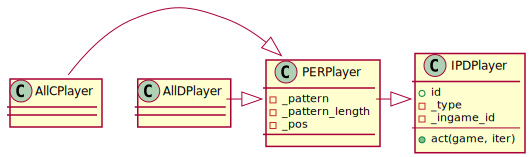

In [56]:
%%plantuml uml/periodic-players-1

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class PERPlayer{
    -_pattern
    -_pattern_length
    -_pos
}
PERPlayer -r-|> IPDPlayer
AllCPlayer -r-|> PERPlayer
AllDPlayer -r-|> PERPlayer
@enduml

In [57]:
# %load -s PERPlayer,AllCPlayer,AllDPlayer pd.py
class PERPlayer(IPDPlayer):

    """
    Periodic Player

    Plays a single pattern with periodicity
    """

    def __init__(self, pattern, player_name=None):
        """
        Pattern is a binary array
        """

        if player_name is None:
            player_name = 'PER'

        IPDPlayer.__init__(self, player_name)

        self._pattern = pattern
        self._pattern_length = len(pattern)
        self._pos = 0

    def act(self, game, iter):
        return self._pattern[iter % self._pattern_length]

    def set_ingame_id(self, id):
        IPDPlayer.set_ingame_id(self, id)
        self._pos = 0

class AllCPlayer(PERPlayer):

    """
    A Player that always cooperates
    """

    def __init__(self):
        """
        WRITEME
        """
        allc_pattern = numpy.array([0])
        PERPlayer.__init__(self, allc_pattern, 'AllC')


class AllDPlayer(PERPlayer):

    """
    A Player that always defects
    """

    def __init__(self):
        """
        WRITEME
        """
        alld_pattern = numpy.array([1])
        PERPlayer.__init__(self, alld_pattern, 'AllD')



##(Memory-0) Stochastic Player
###Random Player (RAND)
**RAND** is a stochastic player that can be considered a special case of the Memory-N family (0 length history).


It decides to defect according to the toss of a Bernulli with parameter $\theta$. To increase diversity, for the following simulations $\theta=0.5$ (should have I created other subclasses, e.g. _RAND05_?)

RAND against AllD would lose almost $1-\theta$ of the times, while winning $\theta$ times against AllC.


In [58]:
# %load -s RANDPlayer pd.py
class RANDPlayer(IPDPlayer):

    """
    A Player that randomly defects with probability \theta
    """

    def __init__(self, theta=0.5):
        """
        Just storing theta
        """
        IPDPlayer.__init__(self, 'RAND')
        self._prob = theta

    def act(self, game, iter):
        """
        Return 'D' with probability theta
        """
        if numpy.random.rand() < self._prob:
            return 1
        else:
            return 0


From now on, after introducing new player strategies, the outcome of all the possible matchups for pairwise IPD games are shown for the known agents. The main idea is to evaluate their strengths and weaknesses from the game simulations.

In [ ]:
R = 3.#1.
S = 0.
T = 5.#1.1
P = 1.#0.1
matrix_payoff = numpy.array([[[R, R], [S, T]], [[T, S], [P, P]]])
print('Payoff Matrix\n', matrix_payoff)

In [59]:
player_list = [AllCPlayer(), AllDPlayer(), RANDPlayer()]

n_iters = 20
ipd_game = IPDPairwiseCompetition(player_list, matrix_payoff, n_iters)
sim_res = ipd_game.simulate(printing=True)
sim_res



game #1:
player #0    (AllC): CCCCCCCCCCCCCCCCCCCC  [0.0]
player #1    (AllD): DDDDDDDDDDDDDDDDDDDD  [100.0]

game #2:
player #0    (AllC): CCCCCCCCCCCCCCCCCCCC  [42.0]
player #2    (RAND): DCCCCCDDCDCDCCCCDCCC  [72.0]

game #3:
player #1    (AllD): DDDDDDDDDDDDDDDDDDDD  [56.0]
player #2    (RAND): DDCDCDDCDDCCDCCCCDDD  [11.0]

,types,scores,wins,draws,losses
1,AllD,156,29,11,0
2,RAND,83,6,25,9
0,AllC,42,0,14,26


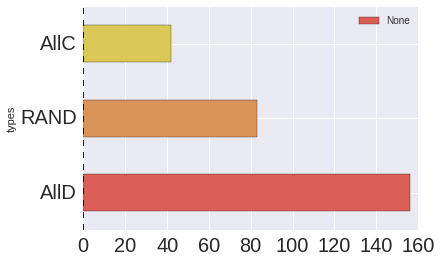

In [60]:
sim_res.plot(kind='barh', y='scores', x='types',color=sns.color_palette("hls", 15), fontsize=20)

##Memory-1 (Stochastic) Players (M1)

_**Memory-1**_ (**M1**) players are more sofisticated: they keep track of the last moves (both theirs and their opponents') and associate a probability distribution for the current decision, given the previous pair of decisions.

An M1 strategy is then specified by four _cooperation probabilities_: $P=\{P_{CC},P_{CD},P_{DC},P_{DD}\}$, where $P_{ab}$ is the probability that the player will cooperate in the present encounter given that the previous encounter was characterized by $(ab)$. 

For each M1 player a _default policy_, as the decision to take when no previous history is available, is assigned.

The next following agents are M1 players that are really not stochastic: their actions can be determined ($P_{ab}=1\vee 0$) exactly by the previous move pair. However putting them into this category facilitates modeling their derivations.


###Tit-For-Tat (TFT)

The strategy that exposed an emergent behaviour in the two tournaments by Axelrod.
The default policy is to cooperate, then it replicates the opponent previous move.

In the framework of M1 Stochastic players, this strategy can be formulated as the probability distributions matrix: $P=\{1,0,1, 0\}$ if the player is the first to play, $P=\{1,1,0,0\}$ otherwise.

###Win-Stay Lose-Shift (WSLS)
The default policy is to cooperate, next decisions are taken as it follows: if in the previous round the player won it applies the same strategy, otherwise if it lost, it changes it.

In terms of the stochastic matrix, the probability distributions are: $P=\{1,0,0,1\}$

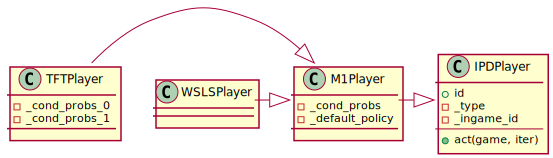

In [61]:
%%plantuml uml/m1-players

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class M1Player{
    -_cond_probs
    -_default_policy
}
class TFTPlayer{
    -_cond_probs_0
    -_cond_probs_1
}
M1Player -r-|> IPDPlayer
TFTPlayer -r-|> M1Player
WSLSPlayer -r-|> M1Player
@enduml

In [62]:
# %load -s M1SPlayer,TFTPlayer,WSLSPlayer pd.py
class M1SPlayer(IPDPlayer):

    """

    Memory-One Stochastic Player

    A player that chooses its action based on a
    conditional probability distribution over the previous moves
    (Memory one)
    At the first round it generate a default policy
    """

    def __init__(self, cond_probs, default_policy, player_type=None):
        """
        cond_probs is a matrix (2x2)
        """

        if player_type is None:
            player_type = 'M1S'

        IPDPlayer.__init__(self, player_type)

        self._cond_probs = cond_probs
        self._default_policy = default_policy

    def act(self, game, iter):
        """
        The probability to emit 'C' is given by the past actions
        """
        if iter == 0:
            return self._default_policy
        else:
            #
            # look at previous actions
            prev_actions = game.get_actions(iter - 1, iter)  # .reshape(2)
            #
            # ask the probability to generate one decision
            coop_prob = self._cond_probs[[[a] for a in prev_actions]]
            random_choice = numpy.random.rand()
            # print('p', self._cond_probs, coop_prob, self._ingame_id)
            if numpy.random.rand() < coop_prob:
                return 0
            else:
                return 1

class TFTPlayer(M1SPlayer):

    """
    Tit-for-Tat

    TFT can be seen as a special case of the   Memory-One Stochastic Player
    where the cond prob distribution for cooperating is (1, 0, 1, 0)
    and the default policy is too cooperate

    """

    def __init__(self):
        """
        Just calling M1SPlayer constructor with right parameters
        """
        #
        # this code is ugly, I need to create the index first
        tft_cond_probs = None
        M1SPlayer.__init__(self, tft_cond_probs, 0, 'TFT')

        self._cond_probs_0 = numpy.zeros((2, 2))
        self._cond_probs_1 = numpy.zeros((2, 2))

        self._cond_probs_1[0, :] = 1.
        self._cond_probs_0[:, 0] = 1.

    def set_ingame_id(self, id):

        IPDPlayer.set_ingame_id(self, id)

        if id == 0:
            self._cond_probs = self._cond_probs_0
        elif id == 1:
            self._cond_probs = self._cond_probs_1

        # print(self._cond_probs, self._ingame_id)

class WSLSPlayer(M1SPlayer):

    """
    Win-Stay Lose-Switch

    If the player won last iter, continue with that strategy,
    if it lost, switch to the opposite
    """

    def __init__(self):
        """
        Just calling M1SPlayer constructor with right parameters
        """

        wsls_cond_probs = numpy.zeros((2, 2))
        M1SPlayer.__init__(self, wsls_cond_probs, 0, 'WSLS')

        self._cond_probs[0, 0] = 1.
        self._cond_probs[1, 1] = 1.


In [63]:
R = 3.#1.
S = 0.
T = 5.#1.1
P = 1.#0.1
matrix_payoff = numpy.array([[[R, R], [S, T]], [[T, S], [P, P]]])
print('Payoff Matrix\n', matrix_payoff)
player_list = [AllCPlayer(), AllDPlayer(), RANDPlayer(), 
              TFTPlayer(), WSLSPlayer()]

n_iters = 20
ipd_game = IPDPairwiseCompetition(player_list, matrix_payoff, n_iters)
sim_res = ipd_game.simulate(printing=True)
sim_res

Payoff Matrix
 [[[ 3.  3.]
  [ 0.  5.]]

 [[ 5.  0.]
  [ 1.  1.]]]


game #1:
player #3    (AllC): CCCCCCCCCCCCCCCCCCCC  [0.0]
player #4    (AllD): DDDDDDDDDDDDDDDDDDDD  [100.0]

game #2:
player #3    (AllC): CCCCCCCCCCCCCCCCCCCC  [30.0]
player #5    (RAND): CDCDDCCDDDCDCCCDCDDC  [80.0]

game #3:
player #3    (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #6     (TFT): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #4:
player #3    (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #7    (WSLS): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #5:
player #4    (AllD): DDDDDDDDDDDDDDDDDDDD  [56.0]
player #5    (RAND): CDDDDDCCDDCDDCCCCDDC  [11.0]

game #6:
player #4    (AllD): DDDDDDDDDDDDDDDDDDDD  [24.0]
player #6     (TFT): CDDDDDDDDDDDDDDDDDDD  [19.0]

game #7:
player #4    (AllD): DDDDDDDDDDDDDDDDDDDD  [60.0]
player #7    (WSLS): CDCDCDCDCDCDCDCDCDCD  [10.0]

game #8:
player #5    (RAND): CDCDDCDDDCDDCCDDCDCC  [44.0]
player #6     (TFT): CCDCDDCDDDCDDCCDDCDC  [44.0]

game #9:
player #5    (RAND): DCCDCDDDCDCCCDDDDCCC 

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:39: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


,types,scores,wins,draws,losses
4,AllD,240,40,40,0
5,RAND,186,21,41,18
6,TFT,183,6,67,7
7,WSLS,171,3,62,15
3,AllC,150,0,50,30


AllD has less advantage, why?

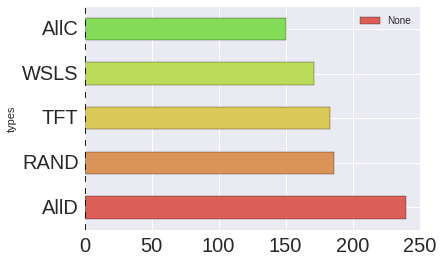

In [64]:
sim_res.plot(kind='barh', y='scores', x='types',color=sns.color_palette("hls", 15), fontsize=20)

##Tit-For-Tat Variants

The enormous popularity of TFT created different versions that changed its default policy or tried to be less cooperative or even more.

One strategy that has not been implemented, even if almost as famous, is **Tit-For-Two-Tats** (TFTT), that is even more forgiving than TFT, allowing two consecutive defections before retaliating.

###Suspicious Tit-For-Tat (STFT)

Like TFT, but the default policy is to _defect_.
More than everything this has been created to predate TFT, against it it will win by $T$ (after that, they both cooperate).

###Generous Tit-For-Tat (GTFT)

Like TFT, but defects not always but only with a probability $\theta$.
In this case, 

The probability matrix can be rewritten as $P=\{1,\theta,1, \theta\}$ in the case of being first.

###Reverse Tit-For-Tat (RTFT)

Default policy is to defect, then it does the opposite of what the opponent did in the previous step.
The probability matrix can be rewritten as $P=\{0,1,0,1\}$

###Adaptive Tit-For-Tat (ATFT)

Adapts the new decision by smoothing of a factor $\theta$ a continuous variable "world" that aggregates the history of the opponent's moves.

This one, by keeping track of an aggregate over all past opponent's actions, is something more than an M1 model in truth.


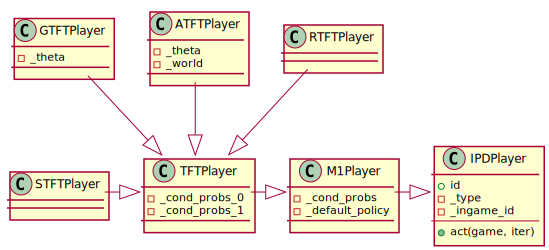

In [65]:
%%plantuml uml/tft-variants-players

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class M1Player{
    -_cond_probs
    -_default_policy
}
class TFTPlayer{
    -_cond_probs_0
    -_cond_probs_1
}
class GTFTPlayer{
    -_theta
}
class ATFTPlayer{
    -_theta
    -_world
}
M1Player -r-|> IPDPlayer
TFTPlayer -r-|> M1Player
STFTPlayer -r-|> TFTPlayer
GTFTPlayer --|> TFTPlayer
RTFTPlayer --|> TFTPlayer
ATFTPlayer --|> TFTPlayer
@enduml

In [66]:
# %load -s STFTPlayer,GTFTPlayer,RTFTPlayer,ATFTPlayer pd.py
class STFTPlayer(TFTPlayer):

    """
    Suspicious Tit-for-Tat

    Like TFT, but default policy is to defect on the first move

    """

    def __init__(self):
        """
        Just calling TFTPlayer constructor with right parameters
        """

        TFTPlayer.__init__(self)
        self._default_policy = 1
        self._type = 'STFT'

class GTFTPlayer(TFTPlayer):

    """
    Generous Tit-for-Tat

    Like TFT, but defects not always but only with a probability theta

    """

    def __init__(self, theta=0.3):
        """
        Just calling M1SPlayer constructor with right parameters
        """
        #
        # this code is ugly, I need to create the index first
        gtft_cond_probs = None
        M1SPlayer.__init__(self, gtft_cond_probs, 0, 'GTFT')

        self.theta = theta

        self._cond_probs_0 = numpy.array([[theta for i in range(2)] for j in range(2)])
        self._cond_probs_1 = numpy.array([[theta for i in range(2)] for j in range(2)])

        self._cond_probs_1[0, :] = 1.
        self._cond_probs_0[:, 0] = 1.

class RTFTPlayer(TFTPlayer):

    """
    Reverse Tit-for-Tat

    Defects on the first move, then plays the reverse of the opponent’s last move

    """

    def __init__(self):
        """
        Just calling M1SPlayer constructor with right parameters
        """
        #
        # this code is ugly, I need to create the index first
        rtft_cond_probs = None
        M1SPlayer.__init__(self, rtft_cond_probs, 1, 'RTFT')

        self._cond_probs_0 = numpy.zeros((2, 2))
        self._cond_probs_1 = numpy.zeros((2, 2))

        self._cond_probs_1[1, :] = 1.
        self._cond_probs_0[:, 1] = 1.

class ATFTPlayer(TFTPlayer):

    """
    Adaptive Tit-for-Tat
    1-memory model smoothed with previous adversarial observation
    """

    def __init__(self, theta=0.6):
        TFTPlayer.__init__(self)
        self._type = 'ATFT'
        self._theta = theta
        self._world = None

    def set_ingame_id(self, id):
        IPDPlayer.set_ingame_id(self, id)
        self._world = None

    def act(self, game, iter):

        if iter == 0:
            self._world = 0
            return self._default_policy

        prev_actions = game.get_actions(iter - 1, iter)
        adv_id = 1 - self._ingame_id
        prev_actions = prev_actions.reshape(prev_actions.shape[0])
        if prev_actions[adv_id] == 0:
            world_update = (1 - self._world)
        else:
            world_update = (0 - self._world)

        self._world = self._world + self._theta * world_update

        if self._world >= 0.5:
            return 0
        else:
            return 1


In [67]:
R = 3.#1.
S = 0.
T = 5.#1.1
P = 1.#0.1
matrix_payoff = numpy.array([[[R, R], [S, T]], [[T, S], [P, P]]])
print('Payoff Matrix\n', matrix_payoff)
player_list = [AllCPlayer(), AllDPlayer(), RANDPlayer(), 
              TFTPlayer(), WSLSPlayer(), STFTPlayer(), GTFTPlayer(), RTFTPlayer(), ATFTPlayer()]

n_iters = 20
ipd_game = IPDPairwiseCompetition(player_list, matrix_payoff, n_iters)
sim_res = ipd_game.simulate(printing=True)
sim_res

Payoff Matrix
 [[[ 3.  3.]
  [ 0.  5.]]

 [[ 5.  0.]
  [ 1.  1.]]]


game #1:
player #8    (AllC): CCCCCCCCCCCCCCCCCCCC  [0.0]
player #9    (AllD): DDDDDDDDDDDDDDDDDDDD  [100.0]

game #2:
player #8    (AllC): CCCCCCCCCCCCCCCCCCCC  [15.0]
player #10   (RAND): CDDDDDDCDDDDCDCDDCDD  [90.0]

game #3:
player #8    (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #11    (TFT): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #4:
player #8    (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #12   (WSLS): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #5:
player #8    (AllC): CCCCCCCCCCCCCCCCCCCC  [57.0]
player #13   (STFT): DCCCCCCCCCCCCCCCCCCC  [62.0]

game #6:
player #8    (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #14   (GTFT): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #7:
player #8    (AllC): CCCCCCCCCCCCCCCCCCCC  [0.0]
player #15   (RTFT): DDDDDDDDDDDDDDDDDDDD  [100.0]

game #8:
player #8    (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #16   (ATFT): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #9:
player #9    (AllD): DDDDDDDDDDDDDDDDDDDD 

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:39: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


,types,scores,wins,draws,losses
9,AllD,440,70,90,0
11,TFT,403,20,119,21
16,ATFT,399,20,119,21
15,RTFT,393,54,63,43
14,GTFT,387,5,134,21
10,RAND,375,47,72,41
13,STFT,373,40,83,37
12,WSLS,360,14,116,30
8,AllC,312,0,104,56


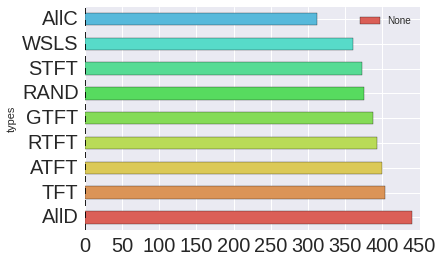

In [68]:
sim_res.plot(kind='barh', y='scores', x='types',color=sns.color_palette("hls", 15), fontsize=20)

##History Based Players (HBP)

These players use directly the history of previous moves done by the opponent to somehow estimate its future behaviour.
To get this kind of information they access the field _actions_ of the currently associated object _IPDGame_.

They inherit from the abstract class *HBPlayer* that provides the method _ _get_history(iter)_ to access the previous actions.


###Soft Majority (SM)

_**Soft Majority**_ (**SM**) Cooperates on the first move, and cooperates as long as the number of times the opponent has cooperated is greater than or equal to the number of times it has defected, else it defects.

###Hard Majority (HM)

Similarly to SM, _**Hard majority**_, looks at the previous numbers of defects but is less cooperative: Defects on the first move, and defects if the number of defections of the opponent is greater than or equal to the number of times it has cooperated, otherwise it cooperates.

###Predictive History Based (PHB)

This version embeds a rational, Nash, player behaviour that tries to predict the opponent moves by applying an exponential smoothing of the first order (with parameter $\alpha$) and then, according to that,tries to maximise its payoff by directly looking at the game payoff matrix.

With a fixed payoff matrix, this equals to cooperating on the first move, then always defecting.

###GRIM Player (GRIM)

**GRIM** is a particular case of a history based player, the history is monitored until the opponent defects for the first time, after that its behaviour is labeled as unreliable, thus the player always defects (AllD). It starts by always cooperating (AllC).


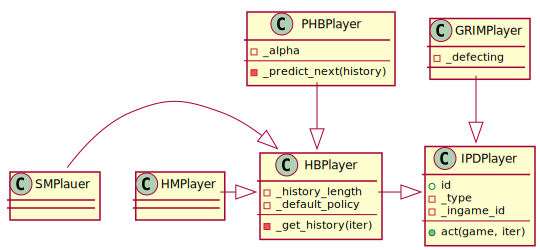

In [69]:
%%plantuml uml/history-based-players

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class HBPlayer{
    -_history_length
    -_default_policy
    --
    -_get_history(iter)
}
class GRIMPlayer{
    -_defecting
}
class PHBPlayer{
    -_alpha
    --
    -_predict_next(history)
}
HBPlayer -r-|> IPDPlayer
GRIMPlayer --|> IPDPlayer
SMPlauer -r-|> HBPlayer
HMPlayer -r-|> HBPlayer
PHBPlayer --|> HBPlayer
@enduml

In [70]:
# %load -s GRIMPlayer pd.py
class GRIMPlayer(IPDPlayer):

    """
    Grim Trigger

    Starts cooperating, when the other player defects, always defects
    """

    def __init__(self):
        IPDPlayer.__init__(self, 'GRIM')
        self._defecting = False

    def act(self, game, iter):
        if self._defecting:
            return 1
        else:
            if iter > 0:
                #
                # look at the previous action
                prev_actions = game.get_actions(iter - 1, iter)
                adv_id = 1 - self._ingame_id
                prev_actions = prev_actions.reshape(prev_actions.shape[0])
                if prev_actions[adv_id] == 1:
                    self._defecting = True
                    return 1
                else:
                    return 0

            return 0

    def set_ingame_id(self, id):
        IPDPlayer.set_ingame_id(self, id)
        #
        # this is ugly btw
        self._defecting = False


In [71]:
# %load -s HBPlayer,SMPlayer,HMPlayer,PHBPlayer pd.py
class HBPlayer(IPDPlayer):

    """
    History-Based Player
    """

    def __init__(self, default_policy, history_length=None, player_type=None):
        """
        history_length == None means full history
        """

        if player_type is None:
            player_type = 'HBP'

        IPDPlayer.__init__(self, player_type)

        self._default_policy = default_policy
        self._history_length = history_length

    # def act(self, game, iter):
    #     """
    #     WRITEME
    #     """
    #     if iter == 0:
    #         return self._default_policy

    def _get_history(self, game, iter):
        """
        """
        adv_id = 1 - self._ingame_id
        iter_start = 0

        if self._history_length is not None:
            iter_start = iter - self._history_length

        return game.get_actions(iter_start, iter)[adv_id, :]

class SMPlayer(HBPlayer):

    """
    Soft-Majority

    Cooperates on the first move, and cooperates as long as the number
    of times the opponent has cooperated is greater than or equal to
    the number of times it has defected, else it defects
    """

    def __init__(self, history_length=None):
        """
        WRITEME
        """
        HBPlayer.__init__(self, 0, history_length, 'SM')

    def act(self, game, iter):
        #
        # apply default policy
        if iter == 0:
            return self._default_policy

        #
        # get history
        adv_action_history = self._get_history(game, iter)
        # print('history', adv_action_history)
        n_defects = adv_action_history.sum()
        if n_defects * 2 <= len(adv_action_history):
            return 0
        else:
            return 1

class HMPlayer(HBPlayer):

    """
    Hard-Majority

    Defects on the first move, and defects if the number of defections
    of the opponent is greater than or equal to the number of times
    it has cooperated, otherwise it cooperates
    """

    def __init__(self, history_length=None):
        """
        WRITEME
        """
        HBPlayer.__init__(self, 1, history_length, 'HM')

    def act(self, game, iter):
        #
        # apply default policy
        if iter == 0:
            return self._default_policy

        #
        # get history
        adv_action_history = self._get_history(game, iter)
        # print('history', adv_action_history)
        n_defects = adv_action_history.sum()
        if n_defects * 2 >= len(adv_action_history):
            return 1
        else:
            return 0

class PHBPlayer(HBPlayer):

    """
    Predictive History Based Player

    Tries to predict the opponent move based on its history and
    then tries to maximise its payoff. Using exponential smoothing

    Starts by being cooperative
    """

    def __init__(self, history_length=None, alpha=0.6):
        """
        WRITEME
        """
        HBPlayer.__init__(self, 0, history_length, 'PHB')
        self._alpha = alpha

    def _predict_next(self, history):
        #
        # exponential smoothing on history
        s = history[0]
        for i in range(1, len(history)):
            s = self._alpha * history[i] + (1 - self._alpha) * s

        #
        # binarizing
        if s > 0.5:
            return 1
        else:
            return 0

    def act(self, game, iter):
        #
        # apply default policy
        if iter == 0:
            return self._default_policy

        #
        # get history
        adv_action_history = self._get_history(game, iter)
        adv_id = 1 - self._ingame_id
        adv_next = self._predict_next(adv_action_history)

        strategy = None
        if adv_id == 1:
            strategy = game.payoffs()[:, adv_next, self._ingame_id]
        elif adv_id == 0:
            strategy = game.payoffs()[adv_next, :, self._ingame_id]

        # print('strategy', strategy)
        # print('payoffs', game.payoffs(),
        #       adv_action_history, adv_next, self._ingame_id, strategy, numpy.argmax(strategy))
        return numpy.argmax(strategy)


In [72]:
R = 3.#1.
S = 0.
T = 5.#1.1
P = 1.#0.1
matrix_payoff = numpy.array([[[R, R], [S, T]], [[T, S], [P, P]]])
print('Payoff Matrix\n', matrix_payoff)
player_list = [AllCPlayer(), AllDPlayer(), RANDPlayer(), GRIMPlayer(), 
              TFTPlayer(), WSLSPlayer(), STFTPlayer(), GTFTPlayer(), RTFTPlayer(), ATFTPlayer(),
              SMPlayer(), HMPlayer(), PHBPlayer()]

n_iters = 20
ipd_game = IPDPairwiseCompetition(player_list, matrix_payoff, n_iters)
sim_res = ipd_game.simulate(printing=True)
sim_res

Payoff Matrix
 [[[ 3.  3.]
  [ 0.  5.]]

 [[ 5.  0.]
  [ 1.  1.]]]


game #1:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC  [0.0]
player #18   (AllD): DDDDDDDDDDDDDDDDDDDD  [100.0]

game #2:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC  [27.0]
player #19   (RAND): DCCDDCCDDCCCDDCDCDDD  [82.0]

game #3:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #20   (GRIM): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #4:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #21    (TFT): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #5:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #22   (WSLS): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #6:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC  [57.0]
player #23   (STFT): DCCCCCCCCCCCCCCCCCCC  [62.0]

game #7:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #24   (GTFT): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #8:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC  [0.0]
player #25   (RTFT): DDDDDDDDDDDDDDDDDDDD  [100.0]

game #9:
player #17   (AllC): CCCCCCCCCCCCCCCCCCCC 

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:39: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


,types,scores,wins,draws,losses
21,TFT,589,30,177,33
26,ATFT,545,30,177,33
19,RAND,542,62,122,56
27,SM,537,29,170,41
24,GTFT,526,14,188,38
18,AllD,520,70,170,0
20,GRIM,517,40,197,3
22,WSLS,507,13,178,49
17,AllC,504,0,168,72
28,HM,500,53,139,48


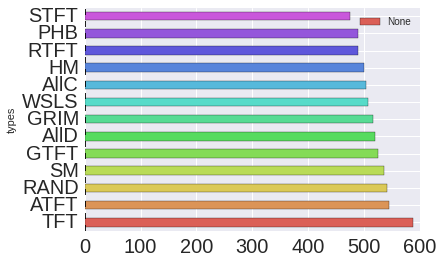

In [73]:
sim_res.plot(kind='barh', y='scores', x='types',color=sns.color_palette("hls", 15), fontsize=20)

###Periodic Players (II)

Lastly, introducing periodic players with period=3.
Their purpose is to break cyclic iteration (of length 2) among other players (by alternating C/D they end up in a draw).

###Periodic DDC (PDDC)

It repeats the three decisons 'DDC'. Pattern $[1,1,0]$ 

###Periodic CCD (PCCD)
It repeats the three decisons 'CCD'. Pattern $[0,0,1]$ 

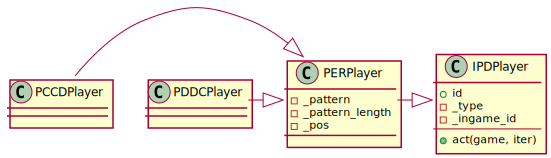

In [74]:
%%plantuml uml/periodic-players-2

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class PERPlayer{
    -_pattern
    -_pattern_length
    -_pos
}
PERPlayer -r-|> IPDPlayer
PCCDPlayer -r-|> PERPlayer
PDDCPlayer -r-|> PERPlayer
@enduml

In [75]:
# %load -s PCCDPlayer,PDDCPlayer pd.py
class PCCDPlayer(PERPlayer):

    """
    Periodic Player with pattern CCD
    """

    def __init__(self):
        ccd_pattern = numpy.array([0, 0, 1])
        PERPlayer.__init__(self, ccd_pattern, 'PCCD')

class PDDCPlayer(PERPlayer):

    """
    Periodic Plauer with pattern DDC
    """

    def __init__(self):
        ddc_pattern = numpy.array([1, 1, 0])
        PERPlayer.__init__(self, ddc_pattern, 'PDDC')


In [76]:
R = 3.#1.
S = 0.
T = 5.#1.1
P = 1.#0.1
matrix_payoff = numpy.array([[[R, R], [S, T]], [[T, S], [P, P]]])
print('Payoff Matrix\n', matrix_payoff)
player_list = [AllCPlayer(), AllDPlayer(), RANDPlayer(), GRIMPlayer(), 
              TFTPlayer(), WSLSPlayer(), STFTPlayer(), GTFTPlayer(), RTFTPlayer(), ATFTPlayer(),
              SMPlayer(), HMPlayer(), PHBPlayer(), PCCDPlayer(), PDDCPlayer()]

n_iters = 20
ipd_game = IPDPairwiseCompetition(player_list, matrix_payoff, n_iters)
sim_res = ipd_game.simulate(printing=True)
sim_res

Payoff Matrix
 [[[ 3.  3.]
  [ 0.  5.]]

 [[ 5.  0.]
  [ 1.  1.]]]


game #1:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC  [0.0]
player #31   (AllD): DDDDDDDDDDDDDDDDDDDD  [100.0]

game #2:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC  [39.0]
player #32   (RAND): DCCCDDCCCCCDDCDCCCCD  [74.0]

game #3:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #33   (GRIM): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #4:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #34    (TFT): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #5:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #35   (WSLS): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #6:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC  [57.0]
player #36   (STFT): DCCCCCCCCCCCCCCCCCCC  [62.0]

game #7:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC  [60.0]
player #37   (GTFT): CCCCCCCCCCCCCCCCCCCC  [60.0]

game #8:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC  [0.0]
player #38   (RTFT): DDDDDDDDDDDDDDDDDDDD  [100.0]

game #9:
player #30   (AllC): CCCCCCCCCCCCCCCCCCCC 

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:39: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


,types,scores,wins,draws,losses
34,TFT,678,44,188,48
31,AllD,648,92,188,0
42,PHB,642,88,186,6
40,SM,641,41,200,39
39,ATFT,638,41,193,46
33,GRIM,629,58,219,3
37,GTFT,610,16,212,52
41,HM,607,66,169,45
35,WSLS,598,21,201,58
44,PDDC,587,79,142,59


In [ ]:
sim_res.plot(kind='barh', y='scores', x='types',color=sns.color_palette("hls", 15), fontsize=20)
#plt.savefig('ex_pairwise.pdf', figsize=(12,8))

###The most balanced strategy

TFT happens to be the most well rounded strategy among all the one tested in these pairwise simulations.
The main advantages of TFT are:

 * being _**nice**_ (**N**), as it starts cooperating
 * _**not a blind optimist**_ (**R**), since it is capable of retaliation when the other player defects
 * being _**forgiving**_ (**F**), since it is able to cooperate again even after a defection
 
 These are characteristics shared by other strategies as well, even among those not derived by TFT:
       
   - RTFT (R)
   - AllC (N, F)
   - AllD (R)
   - STFT (R, F)
   - _**SM**_ (N, R, F)
   - HM (R, F)
   - PCCD (N, F)
   - PDDC (R, F)
   - WSLS (N, R)
   - PHB (N, R)
   - RAND (~R,~F)
   - GRIM (N, R)
   - _**ATFT**_ (N, R, F)
   - _**GTFT**_ (N, R, F)
   
 
 So, why is TFT the best one in these simulations?


##All player classes diagram

In [ ]:
%%plantuml uml/all-players

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class M1Player{
    -_cond_probs
    -_default_policy
}
class TFTPlayer{
    -_cond_probs_0
    -_cond_probs_1
}

M1Player --|> IPDPlayer
TFTPlayer --|> M1Player
WSLSPlayer --|> M1Player

class PERPlayer{
    -_pattern
    -_pattern_length
    -_pos
}
PERPlayer --|> IPDPlayer
PCCDPlayer --|> PERPlayer
PDDCPlayer --|> PERPlayer

class HBPlayer{
    -_history_length
    -_default_policy
}
class GRIMPlayer{
    -_defecting
}
class PHBPlayer{
    -_alpha
    --
    -_predict_next(history)
}
HBPlayer --|> IPDPlayer
GRIMPlayer --|> IPDPlayer
SMPlauer --|> HBPlayer
HMPlayer --|> HBPlayer
PHBPlayer --|> HBPlayer

class GTFTPlayer{
    -_theta
}
class ATFTPlayer{
    -_theta
    -_world
}

STFTPlayer --|> TFTPlayer
GTFTPlayer --|> TFTPlayer
RTFTPlayer --|> TFTPlayer
ATFTPlayer --|> TFTPlayer

AllCPlayer --|> PERPlayer
AllDPlayer --|> PERPlayer

class RANDPlayer{
    -_theta
}
RANDPlayer --|> IPDPlayer
@enduml

##Where is the emergence?

Altruistic behaviour can appear even in an iterated selfish game (Dawkins' point of view).
Can this be proved from a evolutionary point of view? (Darwinian perspective)

## Evolutionary Game

Up to now it must be clear that the _fitness_ of a player strategy, i.e. the amount of reward it is able to achieve compared to all the others present in a two player game, highly depends on these factors:

   * the payoff matrix
   * environmental factors, as the population type proportions
   
In fact, it is legit to think that in precence of a _population_ of players of different types, the fitness of one strategy would differ from another environment with different types proportions.

To investigate this aspect, an evolutionary tournament, mirroring the second tournament held by Axelrod, is simulated.
In it, for $K$ generations, a starting population of $L$ players partecipates into a pairwise exhaustive game like before, after that, proportionally to the scores achieved by each type, a new population of size $L$ is created. And the game starts again.

The main objective is to determine which are the dominant strategies, _evolutionary speaking_.

In [ ]:
%%plantuml uml/class-diagram-full

@startuml
class IPDPlayer{
    +id
    -_type
    -_ingame_id
    --
    +act(game, iter)
}
class IPDGame{
    -_payoffs
    -_players
    -_noise
    +actions
    +rewards
    --
    +payoffs()
    +get_actions(start, end)
    +simulate(iters)
}
class IPDPairwiseCompetition{
    -_payoffs
    -_players
    --
    +simulate(iters)
}
class IPDEvolutionarySimulation{
    -_player_types
    -_payoffs
    -_population
    -_n_generations
    -_n_iters
    -_noise
    -_average
    --
    {static} + create_fixed_generation(player_types, population_per_type)
    {static} + create_generation(player_types, player_likelihoods, population)
    {static} + plot_simulation(frame)
    + simulate(first_generation, n_generations, printing)
}
IPDPlayer "2" *-- "1..*" IPDGame
IPDGame "1..*" -- "1" IPDPairwiseCompetition
IPDPairwiseCompetition "1..*" --* "2..*" IPDPlayer
IPDPairwiseCompetition "1..*" -r- "2..*" IPDEvolutionarySimulation
IPDEvolutionarySimulation "1..*" -r- "1..*"  IPDPlayer
@enduml 

In [ ]:
%%plantuml uml/evolution-activities

@startuml
start
repeat
:simulate pairwise IPD games;
:aggregate scores by **type**;
:compute likelihoods on scores;
:create new generation;
repeat while (another generation?)
stop
@enduml 

In [ ]:
# %load -s IPDEvolutionarySimulation pd.py
class IPDEvolutionarySimulation(object):

    """
    Simulating evolving generations of a population by playing
    several times a simulation of IDP between individuals of that population
    """

    @classmethod
    def create_fixed_generation(cls, player_types, population_per_type):
        """
        player_types: an array of N player classes
        population_per_type: how many instances per type (S)

        output: an array of size S*N containing instantiated players from sampled types
        """

        #
        # instantiating a fixed number of players for each type
        sampled_players = []
        for player_type, player_class in player_types.items():
            for i in range(population_per_type):
                sampled_players.append(player_class())

        assert len(sampled_players) == (population_per_type * len(player_types))

        return sampled_players

    @classmethod
    def create_generation_numpy_old(cls, player_types, player_likelihoods, population):
        """
        player_types: an array of N player classes
        player_likelihoods: an array of N probabilities (sum to 1)
        population: the size of the output array (S)

        output: an array of size S containing instantiated players from sampled types
        """
        print(player_types.values())
        #
        # random sample, according to a proportion, from the types
        sampled_types = numpy.random.choice(list(player_types.values()),
                                            size=population,
                                            p=player_likelihoods)

        #
        # now instantiating them
        sampled_players = []
        for player_type in sampled_types:
            sampled_players.append(player_type())

        assert len(sampled_players) == population
        return sampled_players

    @classmethod
    def create_generation_numpy(cls, player_types, player_likelihoods, population):
        """
        player_types: an array of N player classes
        player_likelihoods: an array of N probabilities (sum to 1)
        population: the size of the output array (S)

        output: an array of size S containing instantiated players from sampled types
        """
        print(player_types.values())
        #
        # random sample, according to a proportion, from the types
        sampled_types = numpy.random.choice(player_likelihoods.index.tolist(),
                                            size=population,
                                            p=player_likelihoods.values)

        #
        # now instantiating them
        sampled_players = []
        for p_type in sampled_types:
            sampled_players.append(player_types[p_type]())

        assert len(sampled_players) == population
        return sampled_players

    @classmethod
    def create_generation(cls, player_types, player_likelihoods, population):
        """
        player_types: an array of N player classes
        player_likelihoods: a Series of N probabilities (sum to 1)
        population: the size of the output array (S)

        output: an array of size S containing instantiated players from sampled types
        """
        #
        # from likelihoods to frequencies

        freqs = {}
        count = 0
        for index, row in player_likelihoods.iteritems():

            row_count = int(row * population)
            if count + row_count > population:
                row_count = population - count
            count += row_count

            freqs[index] = row_count

        #
        # remaining ones? assign them random
        if count < population:
            rem_count = population - count
            for _c in range(rem_count):
                rand_type = numpy.random.choice(list(freqs.keys()))
                freqs[rand_type] += 1

        sampled_players = []
        for p_type, count in freqs.items():
            for i in range(count):
                sampled_players.append(player_types[p_type]())

        # #
        # # now instantiating them
        # sampled_players = []
        # for player_type in sampled_types:
        #     sampled_players.append(player_type
        #                           ())

        assert len(sampled_players) == population
        return sampled_players

    def __init__(self,
                 player_types,
                 payoffs,
                 n_iters,
                 population=100,
                 n_generations=100,
                 average=False,
                 obs_noise=0.0):
        """
        WRITEME
        """
        self._player_types = player_types
        self._payoffs = payoffs
        self._population = population
        self._n_generations = n_generations
        self._n_iters = n_iters
        self._noise = obs_noise
        self._average = average

    @classmethod
    def count_players(cls, generation):
        counts = {}
        for p in generation:
            if p._type in counts:
                counts[p._type] += 1
            else:
                counts[p._type] = 1
        return counts

    @classmethod
    def plot_simulation(cls, frame):

        #
        # define a dictionary of styles
        player_style_dict = {'AllC': '-', 'AllD': '-', 'PCCD': '-', 'PDDC': '-',
                             'RAND': ':', 'GRIM': ':',
                             'TFT': '--', 'ATFT': '--', 'STFT': '--', 'GTFT': '--',
                             'RTFT': '--', 'WSLS': '-.', 'SM': '-.', 'HM': '-.', 'PHB': '-.'}
        columns = list(frame.columns.values)
        sns.color_palette("husl", len(columns))

        line_handles = []
        for c in columns:
            ax, = plt.plot(frame[c], linestyle=player_style_dict[c], label=c,
                           linewidth=4)
            line_handles.append(ax)
        plt.legend(handles=line_handles, loc=2)
        plt.show()

    def _count_to_frame(self, counts):
        """
        WRITEME
        """
        n_generations = len(counts)
        indexes = numpy.arange(n_generations)

        types_dict = {p_type: [] for p_type, _p_class in self._player_types.items()}
        #
        # creating it and filling with zeros
        frame = pandas.DataFrame(0, columns=list(self._player_types.keys()),
                                 index=indexes)

        for g in range(n_generations):
            frame.loc[g] = pandas.Series(counts[g])
            # for p_type, p_count in counts[g].items():
            #     types_dict[p_type].append()

        frame = frame.fillna(0)
        return frame

    def simulate(self, first_generation, n_generations=None, printing=False):
        """
        WRITEME
        """
        #
        # simulating generations
        if n_generations is None:
            n_generations = self._n_generations

        #
        # storing the generation on which starting the simulation
        current_generation = first_generation

        #
        #
        count_history = [IPDEvolutionarySimulation.count_players(current_generation)]
        for g in range(n_generations):

            print('### generation {0}/{1}'.format(g + 1, n_generations))
            #
            # creating a pairwise game simulation
            pairwise_game = IPDPairwiseCompetition(current_generation,
                                                   self._payoffs,
                                                   self._n_iters,
                                                   self._noise)
            #
            # simulate it
            sim_results = pairwise_game.simulate(printing=False)
            # print('sim res')
            # print(sim_results)

            #
            # aggregate by player type
            agg_function = numpy.sum
            if self._average:
                agg_function = numpy.mean
            agg_results = sim_results.groupby('types').aggregate(agg_function)
            # print('agg res')
            # print(agg_results)

            #
            # computes the likelihoods on the scores
            likelihoods = agg_results['scores'] / agg_results['scores'].sum()
            print('likelihoods:', likelihoods)

            #
            # create a new generation
            current_types_set = set([p._type for p in current_generation])
            current_types = {p_type: p_class for p_type, p_class in self._player_types.items() if
                             p_type in current_types_set}
            current_generation =\
                IPDEvolutionarySimulation.create_generation(current_types,
                                                            likelihoods,
                                                            self._population)

            # print(counts)
            count_history.append(IPDEvolutionarySimulation.count_players(current_generation))
        #
        # creating dataframe
        frame = self._count_to_frame(count_history)
        print(frame)

        return frame


In [ ]:
plt.rcParams['figure.figsize'] = (14.0, 8.0)

PLAYER_TYPES = {'WSLS': WSLSPlayer,
                'RAND': RANDPlayer,
                'AllD': AllDPlayer,
                'AllC': AllCPlayer,
                'TFT': TFTPlayer,
                'GRIM': GRIMPlayer,
                'STFT': STFTPlayer,
                'GTFT': GTFTPlayer,
                'SM': SMPlayer,
                'HM': HMPlayer,
                'ATFT': ATFTPlayer,
                'PHB': PHBPlayer,
                'RTFT': RTFTPlayer,
                'PCCD': PCCDPlayer,
                'PDDC': PDDCPlayer}

player_list = IPDEvolutionarySimulation.create_fixed_generation(PLAYER_TYPES, 1)

n_iters = 20 

evol_game = IPDEvolutionarySimulation(PLAYER_TYPES,
                                          matrix_payoff,
                                          n_iters,
                                          population=100,
                                          n_generations=50)
frame = evol_game.simulate(player_list, printing=True)

IPDEvolutionarySimulation.plot_simulation(frame)
plt.savefig('sim_evol.pdf')

## Conclusions and Further Works

Be _**nice**_, _**forgiving**_, but _**not too optimistic**_. 
And you'll get a chance of having your genes spread more successfully.


###Wait, what if there was noise in the channel?,
This is a _last minute addition_ (however the code was designed to implement noisy variations from the start). Note the attribute _ _noise_ for the **IPDGame** class'

What will be the impact on M1 and HB players? 

In [ ]:
noise_levels = numpy.logspace(-2, -0.01, 5)
# print(noise_levels)

R = 3.#1.
S = 0.
T = 5.#1.1
P = 1.#0.1
matrix_payoff = numpy.array([[[R, R], [S, T]], [[T, S], [P, P]]])
print('Payoff Matrix\n', matrix_payoff)
player_list = [AllCPlayer(), AllDPlayer(), RANDPlayer(), GRIMPlayer(), 
              TFTPlayer(), WSLSPlayer(), STFTPlayer(), GTFTPlayer(), RTFTPlayer(), ATFTPlayer(),
              SMPlayer(), HMPlayer(), PHBPlayer(), PCCDPlayer(), PDDCPlayer()]

n_iters = 20

for noise in noise_levels:
    print('noise level', noise)
    ipd_game = IPDPairwiseCompetition(player_list, matrix_payoff, n_iters, obs_noise=noise)
    sim_res = ipd_game.simulate(printing=True)
    print(sim_res)
    sim_res.plot(kind='barh', y='scores', x='types',color=sns.color_palette("hls", 15), fontsize=20)